In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-accident-united-kingdom-uk-dataset/UK_Accident.csv
/kaggle/input/road-traffic-accidents/RTA Dataset.csv
/kaggle/input/road-traffic-accidents/cleaned.csv


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score,f1_score,roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold # import KFold
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:

# Load the dataset
df = pd.read_csv(r"/kaggle/input/road-traffic-accidents/RTA Dataset.csv")
df.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

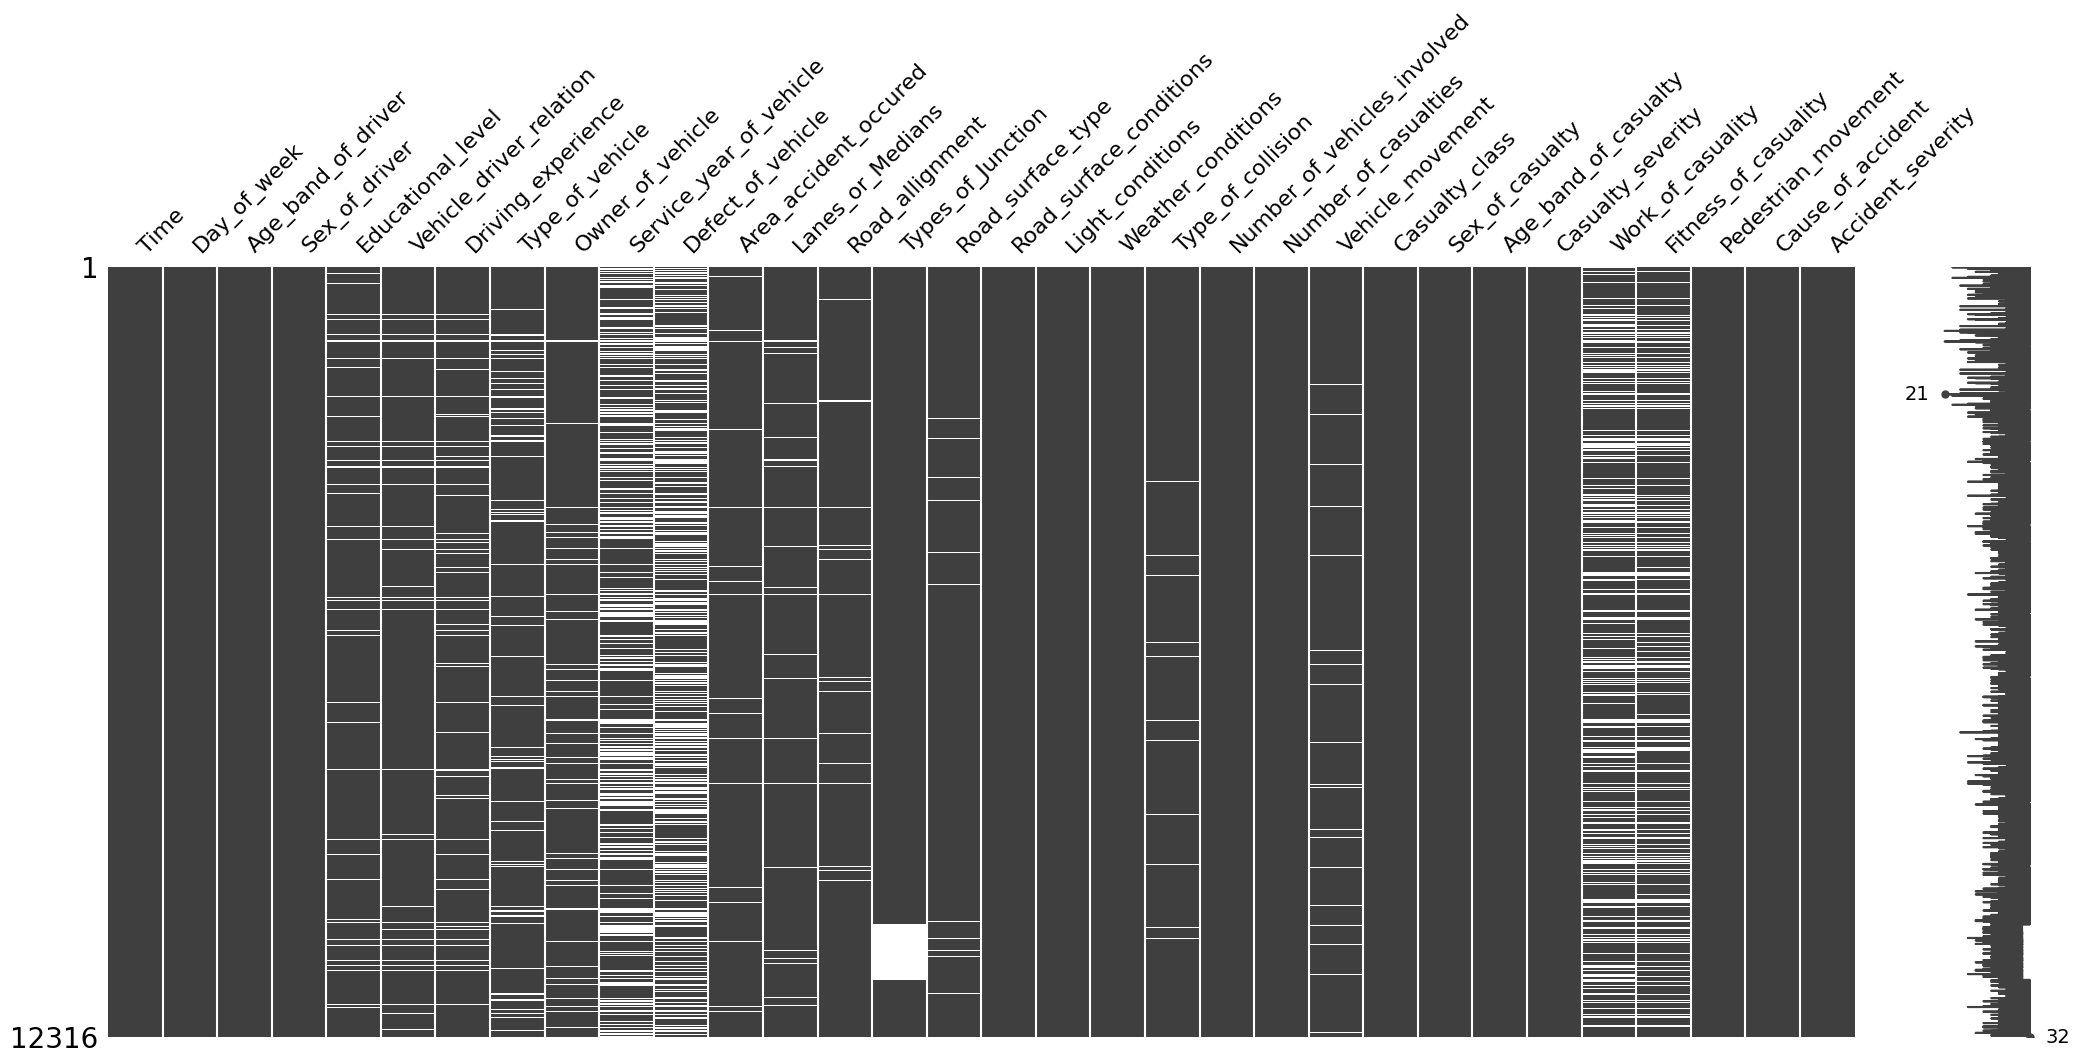

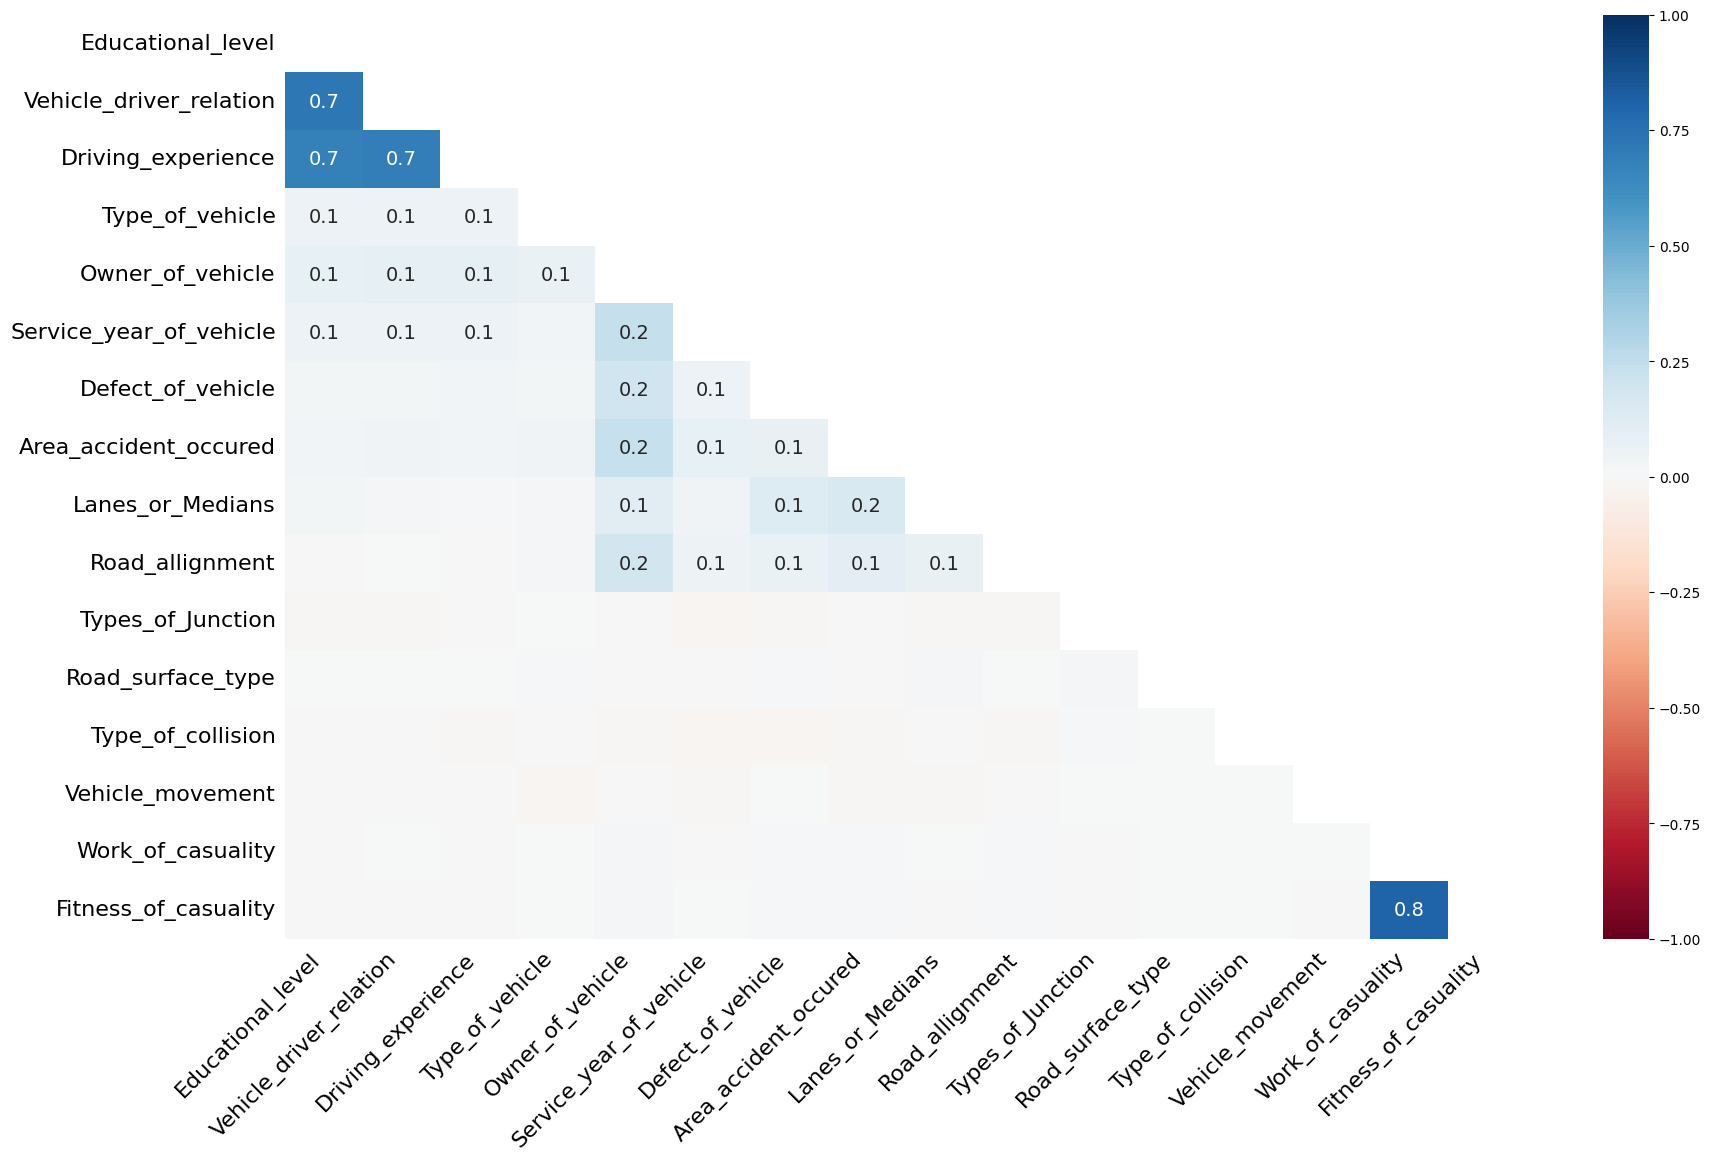

In [5]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df)
plt.show()
msno.heatmap(df)
plt.show()

In [6]:
#Remove duplicate rows
df_no_duplicates = df.drop_duplicates()
df_no_duplicates.duplicated().sum()

0

In [7]:
df.isnull().sum()


Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

In [8]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)


In [9]:
#Categorical Columns: Mode Imputation
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

In [10]:

# Label encoding for categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.shape

(12316, 32)

In [11]:
df.isnull().sum()


Time                           0
Day_of_week                    0
Age_band_of_driver             0
Sex_of_driver                  0
Educational_level              0
Vehicle_driver_relation        0
Driving_experience             0
Type_of_vehicle                0
Owner_of_vehicle               0
Service_year_of_vehicle        0
Defect_of_vehicle              0
Area_accident_occured          0
Lanes_or_Medians               0
Road_allignment                0
Types_of_Junction              0
Road_surface_type              0
Road_surface_conditions        0
Light_conditions               0
Weather_conditions             0
Type_of_collision              0
Number_of_vehicles_involved    0
Number_of_casualties           0
Vehicle_movement               0
Casualty_class                 0
Sex_of_casualty                0
Age_band_of_casualty           0
Casualty_severity              0
Work_of_casuality              0
Fitness_of_casuality           0
Pedestrian_movement            0
Cause_of_a

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Splitting the dataset
X = df.drop(['Accident_severity'], axis=1)
y = df['Accident_severity']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(9852, 31) (2464, 31) (9852,) (2464,)


In [14]:
from sklearn.feature_selection import chi2
import pandas as pd

# Assuming df is your dataset
X = df.drop(columns=['Accident_severity'])  # Replace 'Accident_severity' with your target column name
y = df['Accident_severity']

# Calculate Chi-Square scores for all features
chi_scores, p_values = chi2(X, y)

# Create a DataFrame to store the features, scores, and p-values
chi2_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi-Square Score': chi_scores,
    'p-Value': p_values
})

# Sort features by Chi-Square Score in descending order
chi2_df = chi2_df.sort_values(by='Chi-Square Score', ascending=False)

# Print the DataFrame
print("\nChi-Square Scores:")
print(chi2_df)

# Select the top features
threshold = 0.5 # Define a p-value threshold for significance
selected_features_chi2 = chi2_df[chi2_df['p-Value'] < threshold]['Feature'].tolist()

# Print the selected feature names
print("\nSelected Features (Chi-Square):", selected_features_chi2)

# Filter the dataset with selected features
X_selected_chi2 = X[selected_features_chi2]



Chi-Square Scores:
                        Feature  Chi-Square Score        p-Value
0                          Time        692.221439  4.853159e-151
21         Number_of_casualties         65.123528   7.221136e-15
20  Number_of_vehicles_involved         26.725036   1.573012e-06
17             Light_conditions         16.082824   3.218542e-04
25         Age_band_of_casualty         13.778413   1.018722e-03
19            Type_of_collision         10.096323   6.421128e-03
2            Age_band_of_driver          8.915392   1.158903e-02
15            Road_surface_type          6.994806   3.027591e-02
5       Vehicle_driver_relation          5.345345   6.906738e-02
6            Driving_experience          4.499679   1.054162e-01
11        Area_accident_occured          3.616540   1.639375e-01
12             Lanes_or_Medians          3.281615   1.938235e-01
23               Casualty_class          3.216860   2.002017e-01
30            Cause_of_accident          3.193666   2.025370e-01
14   

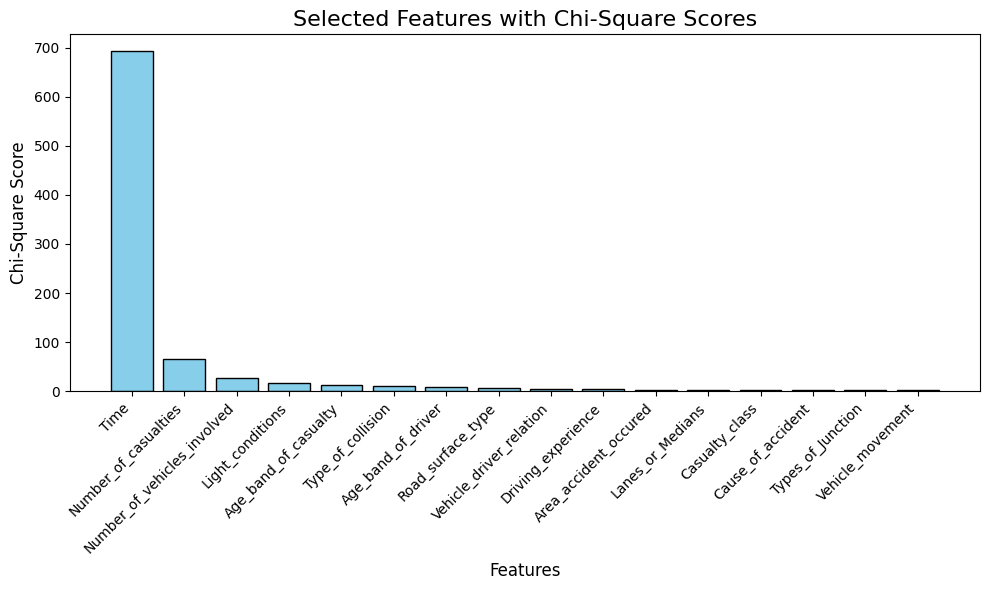

In [15]:
import matplotlib.pyplot as plt

# Create a DataFrame for selected features with their scores
selected_features_df = chi2_df[chi2_df['Feature'].isin(selected_features_chi2)]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(selected_features_df['Feature'], selected_features_df['Chi-Square Score'], color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Selected Features with Chi-Square Scores', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Chi-Square Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


In [16]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected_chi2, y, test_size=0.2, random_state=42)
# Print the shapes to confirm split
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)

Training Features Shape: (9852, 16)
Testing Features Shape: (2464, 16)
Training Target Shape: (9852,)
Testing Target Shape: (2464,)


In [17]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected_chi2, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=30)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24996, 16) (6249, 16) (24996,) (6249,)


In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    
    
    "K-Nearest Neighbors": KNeighborsClassifier(),
   
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, random_state=42),
    "LightGBM Classifier": LGBMClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    results[name] = accuracy


Training Random Forest...
Random Forest Accuracy: 0.9121
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2097
           1       0.87      0.87      0.87      2059
           2       0.88      0.86      0.87      2093

    accuracy                           0.91      6249
   macro avg       0.91      0.91      0.91      6249
weighted avg       0.91      0.91      0.91      6249

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7724
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      2097
           1       0.71      0.66      0.69      2059
           2       0.76      0.78      0.77      2093

    accuracy                           0.77      6249
   macro avg       0.77      0.77      0.77      6249
weighted avg       0.77      0.77      0.77      6249

Training K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.8318
              precision    recall  f1-score   s

Training Random Forest...
Random Forest Accuracy: 0.9121
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2097
           1       0.87      0.87      0.87      2059
           2       0.88      0.86      0.87      2093

    accuracy                           0.91      6249
   macro avg       0.91      0.91      0.91      6249
weighted avg       0.91      0.91      0.91      6249

Confusion Matrix for Random Forest:
 [[2090    3    4]
 [   8 1800  251]
 [  15  268 1810]]


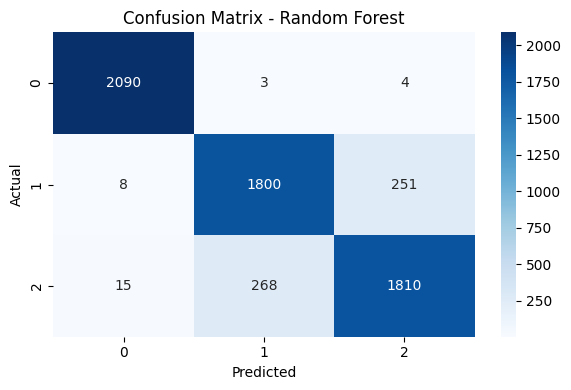

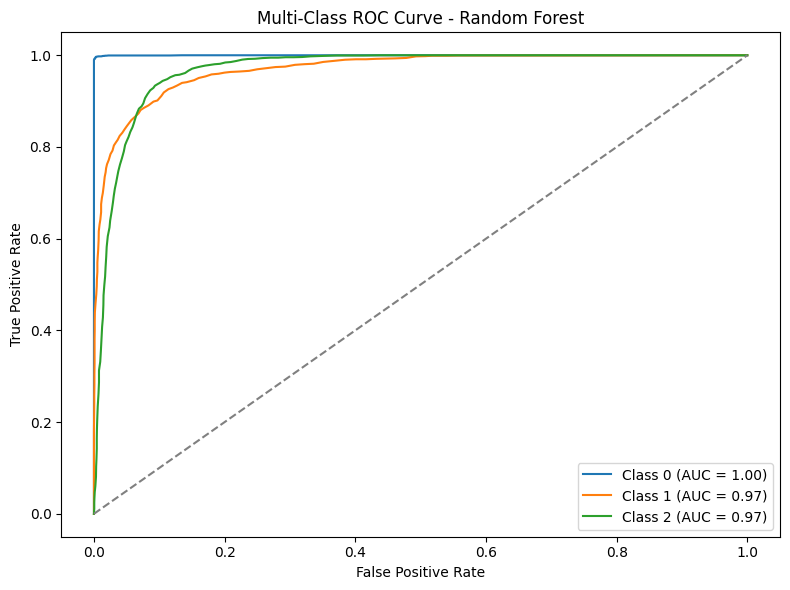

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7724
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      2097
           1       0.71      0.66      0.69      2059
           2       0.76      0.78      0.77      2093

    accuracy                           0.77      6249
   macro avg       0.77      0.77      0.77      6249
weighted avg       0.77      0.77      0.77      6249

Confusion Matrix for Gradient Boosting:
 [[1834  198   65]
 [ 250 1368  441]
 [ 108  360 1625]]


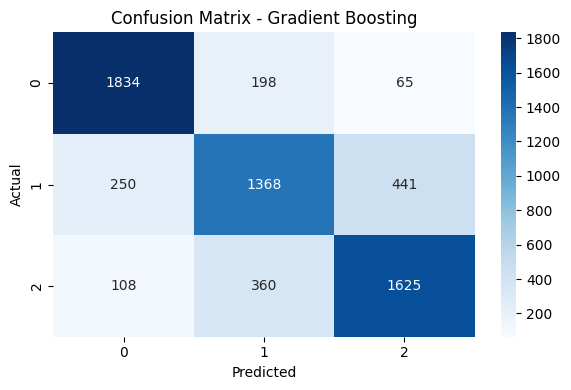

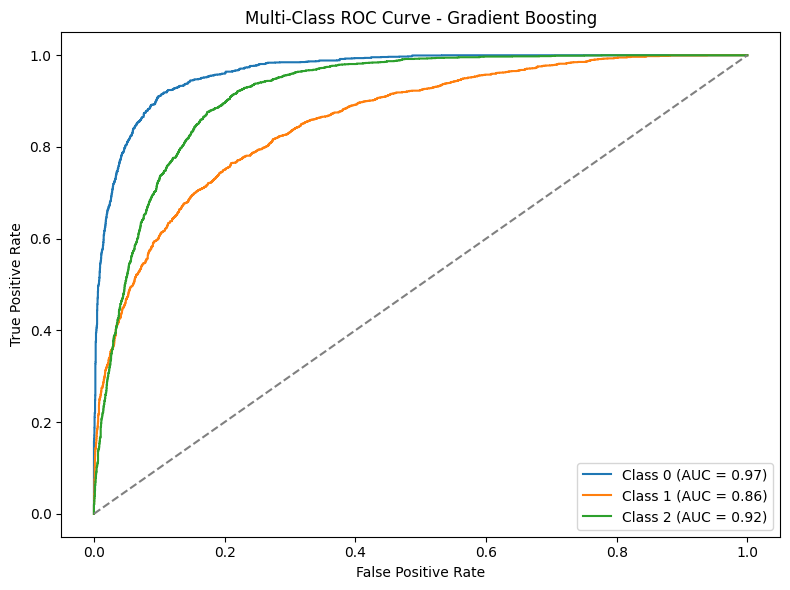

Training K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.8318
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2097
           1       0.72      0.96      0.82      2059
           2       0.96      0.54      0.69      2093

    accuracy                           0.83      6249
   macro avg       0.86      0.83      0.82      6249
weighted avg       0.86      0.83      0.82      6249

Confusion Matrix for K-Nearest Neighbors:
 [[2085    9    3]
 [  33 1985   41]
 [ 200  765 1128]]


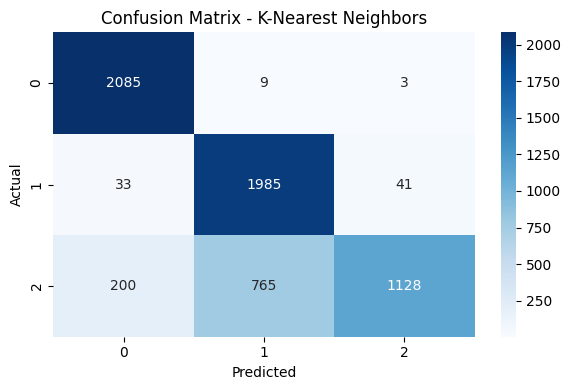

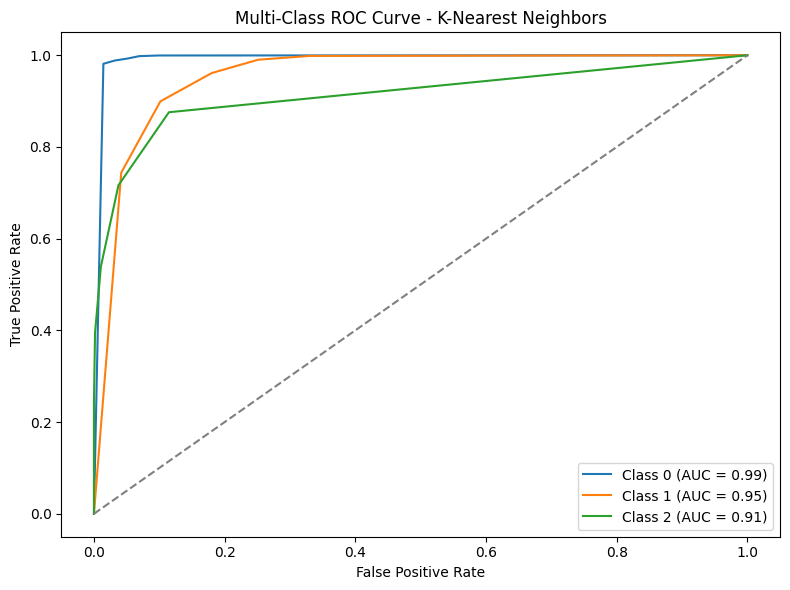

Training XGBoost...
XGBoost Accuracy: 0.9089
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2097
           1       0.88      0.85      0.87      2059
           2       0.86      0.88      0.87      2093

    accuracy                           0.91      6249
   macro avg       0.91      0.91      0.91      6249
weighted avg       0.91      0.91      0.91      6249

Confusion Matrix for XGBoost:
 [[2087    3    7]
 [  14 1744  301]
 [  20  224 1849]]


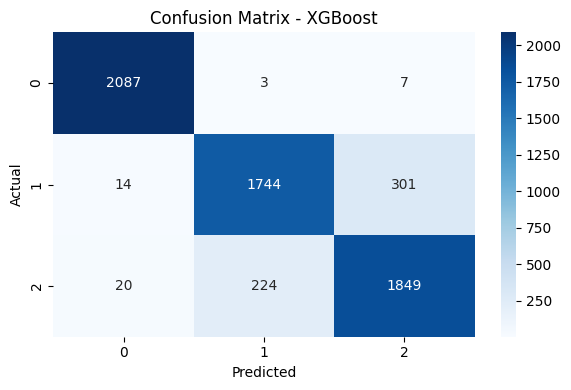

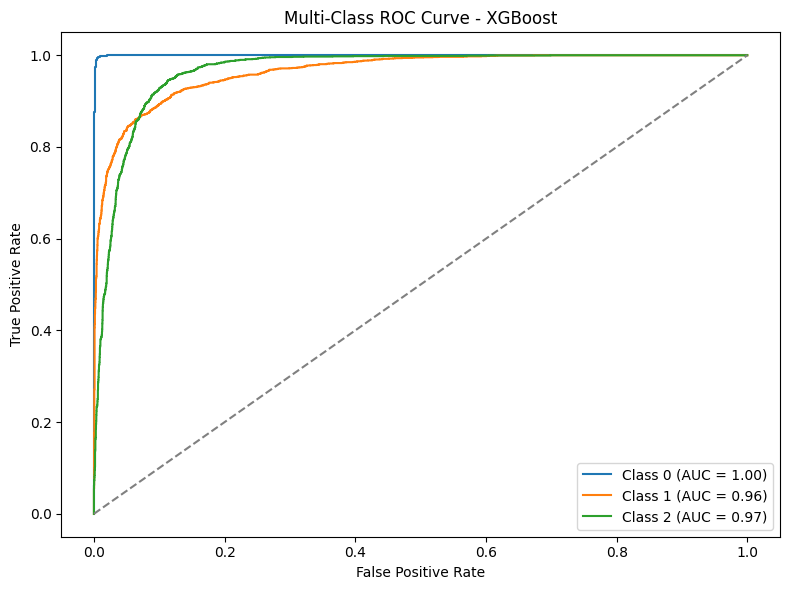

Training CatBoost Classifier...
CatBoost Classifier Accuracy: 0.9016
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2097
           1       0.87      0.84      0.86      2059
           2       0.85      0.87      0.86      2093

    accuracy                           0.90      6249
   macro avg       0.90      0.90      0.90      6249
weighted avg       0.90      0.90      0.90      6249

Confusion Matrix for CatBoost Classifier:
 [[2088    2    7]
 [  21 1731  307]
 [  24  254 1815]]


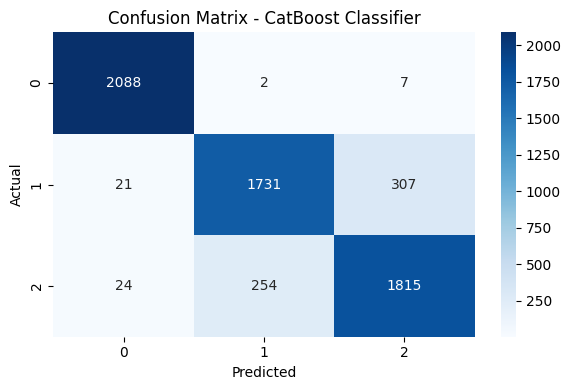

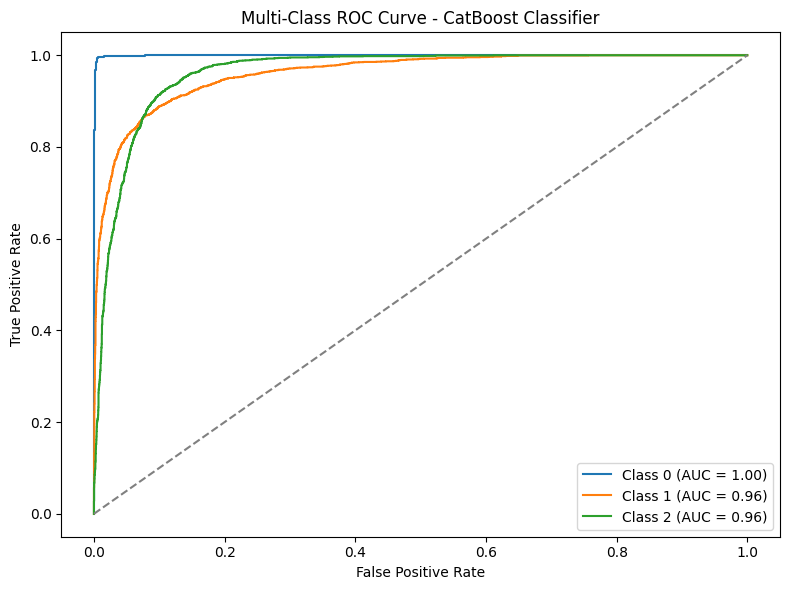

Training LightGBM Classifier...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 24996, number of used features: 16
[LightGBM] [Info] Start training from score -1.100294
[LightGBM] [Info] Start training from score -1.095736
[LightGBM] [Info] Start training from score -1.099813
LightGBM Classifier Accuracy: 0.8829
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2097
           1       0.85      0.80      0.83      2059
           2       0.83      0.85      0.84      2093

    accuracy                           0.88      6249
   macro avg       0.88      0.88      0.88      6249
weighted avg       0.88      0.88      0.88      6249

Confusion Matrix for LightGBM Classi

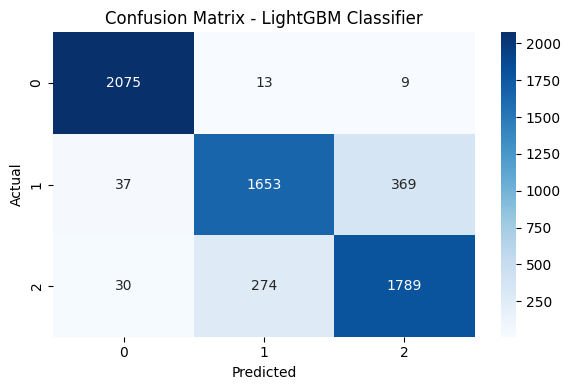

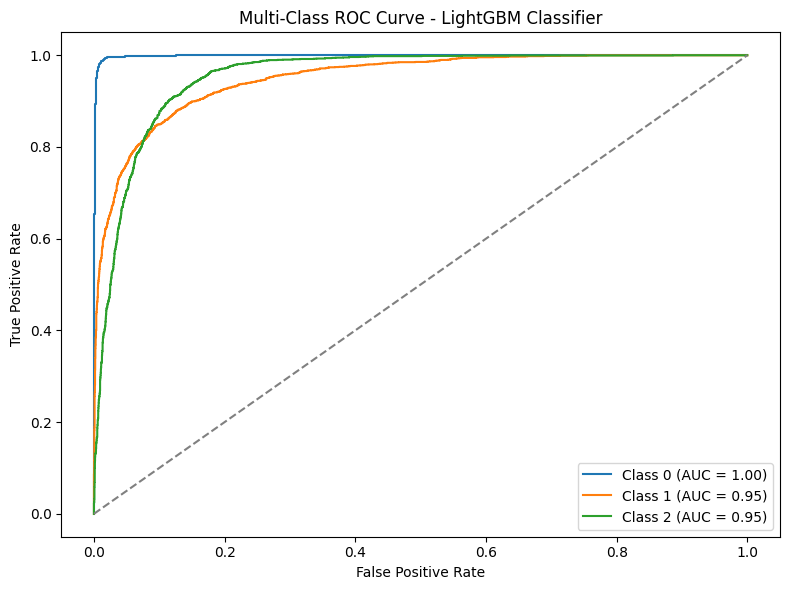

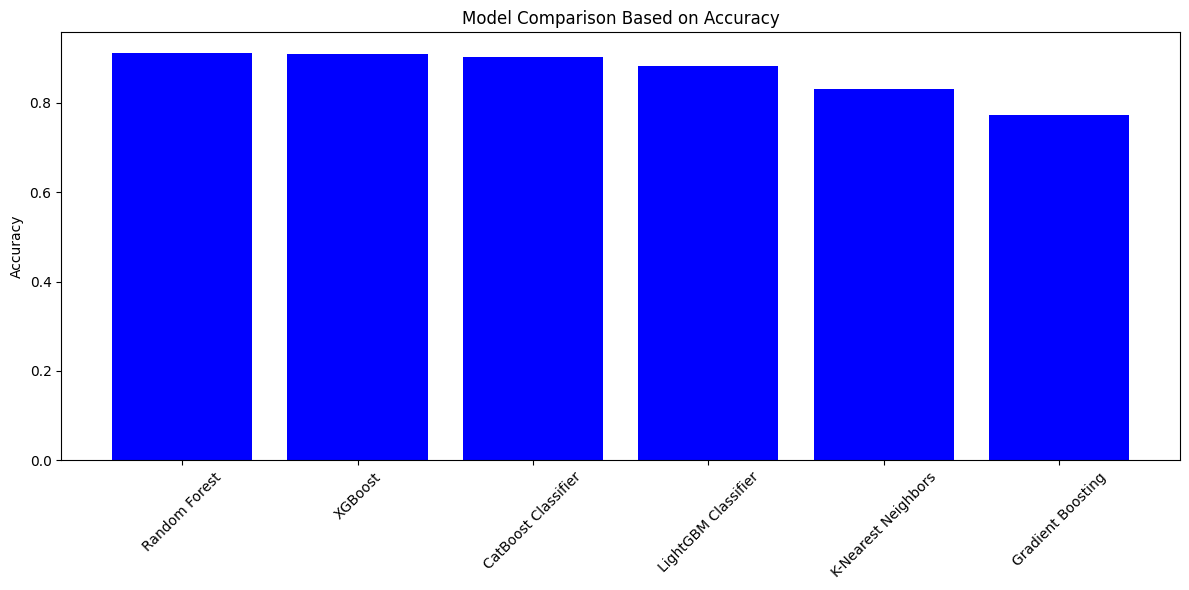

In [19]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target variable for multi-class ROC curve
classes = sorted(y.unique())  # Unique classes in the target
y_test_binarized = label_binarize(y_test, classes=classes)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Function to plot ROC curve
def plot_multi_class_roc(y_test, y_prob, model_name, classes):
    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.title(f"Multi-Class ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = (
        model.predict_proba(X_test)
        if hasattr(model, "predict_proba")
        else None
    )
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    results[name] = accuracy

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {name}:\n", cm)
    plot_confusion_matrix(cm, name)
    
    # Multi-Class ROC Curve
    if y_prob is not None and y_test_binarized.shape[1] == y_prob.shape[1]:
        plot_multi_class_roc(y_test_binarized, y_prob, name, classes)

# Sort results by accuracy
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

# Plot model accuracy
plt.figure(figsize=(12, 6))
plt.bar(sorted_results.keys(), sorted_results.values(), color='blue')
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Comparison Based on Accuracy")
plt.tight_layout()
plt.show()


Training Random Forest...
Confusion Matrix for Random Forest:
 [[2090    3    4]
 [   8 1800  251]
 [  15  268 1810]]


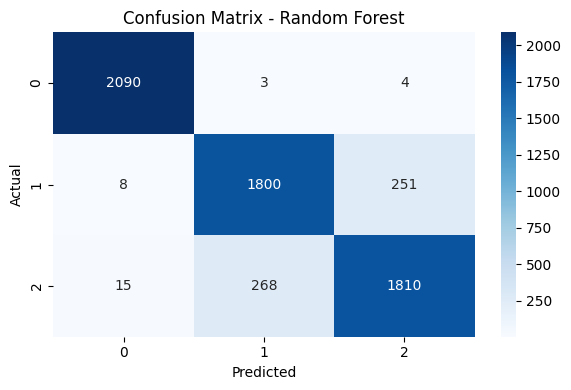

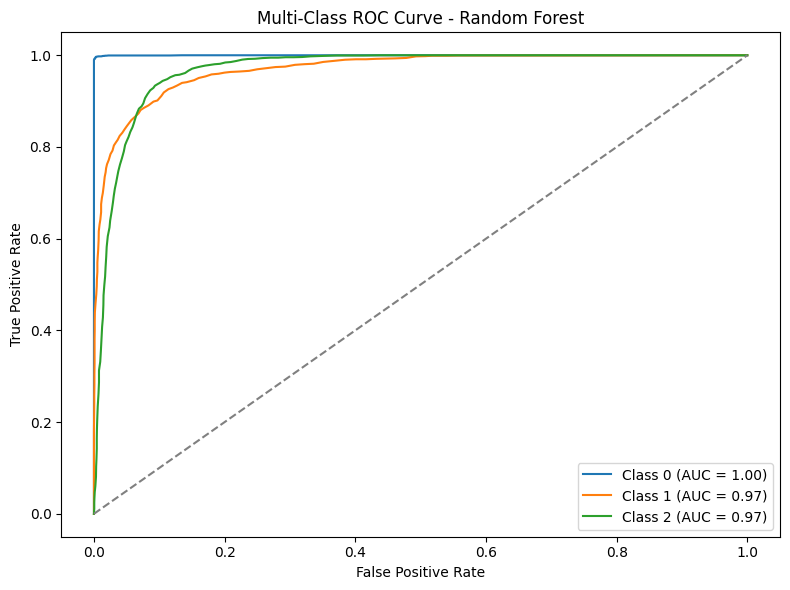

Training Gradient Boosting...
Confusion Matrix for Gradient Boosting:
 [[1834  198   65]
 [ 250 1368  441]
 [ 108  360 1625]]


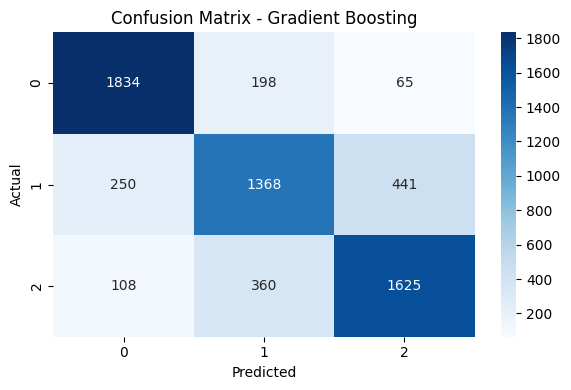

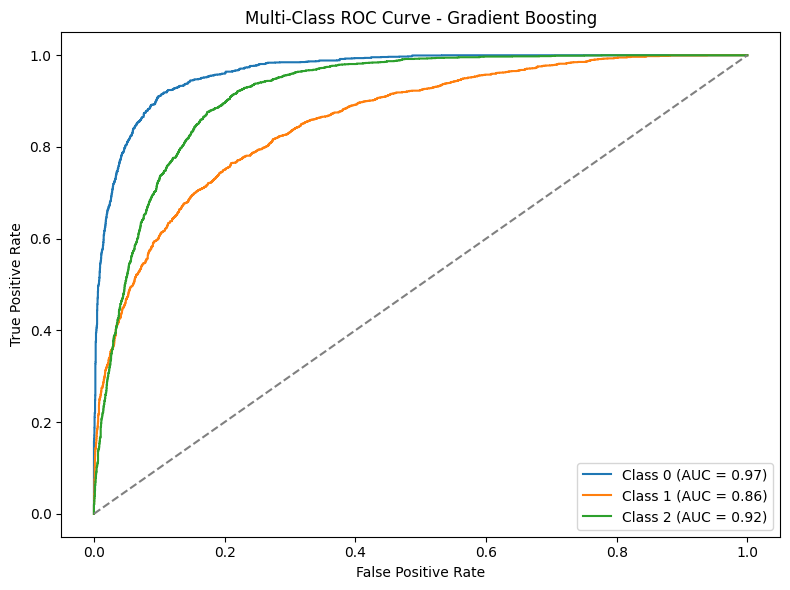

Training K-Nearest Neighbors...
Confusion Matrix for K-Nearest Neighbors:
 [[2085    9    3]
 [  33 1985   41]
 [ 200  765 1128]]


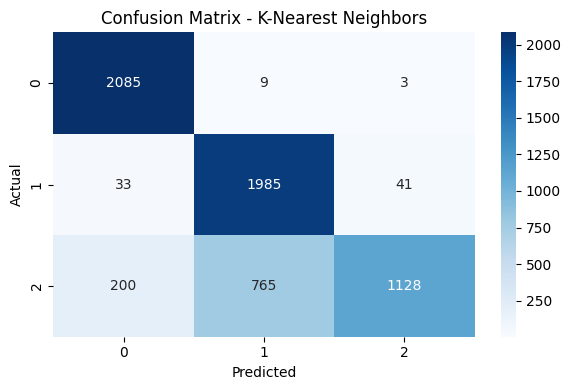

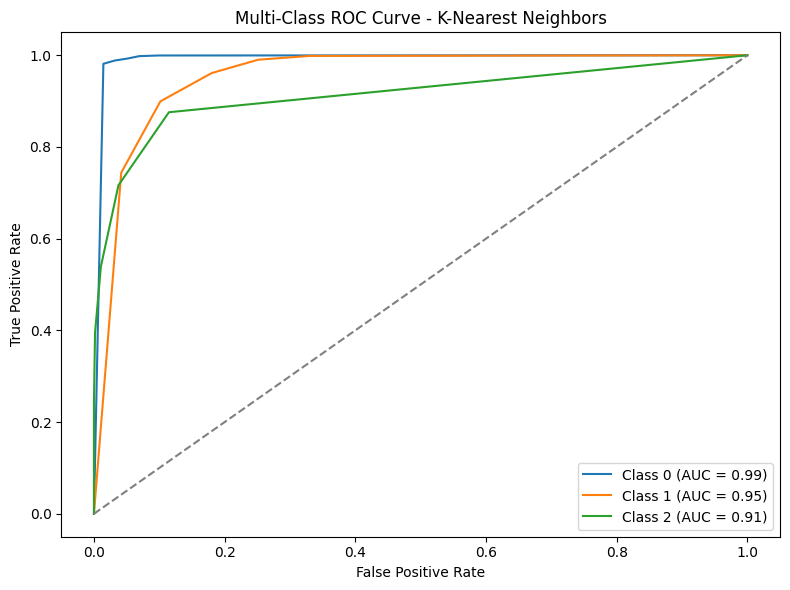

Training XGBoost...
Confusion Matrix for XGBoost:
 [[2087    3    7]
 [  14 1744  301]
 [  20  224 1849]]


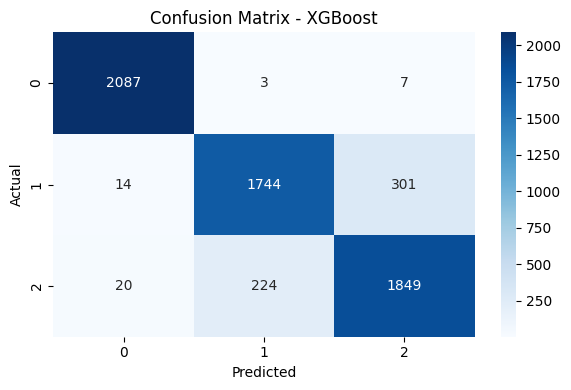

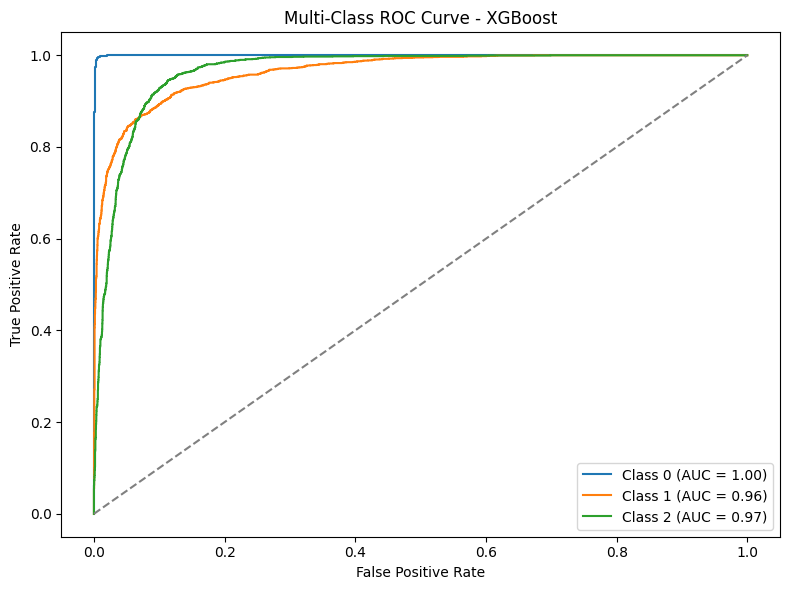

Training CatBoost Classifier...
Confusion Matrix for CatBoost Classifier:
 [[2088    2    7]
 [  21 1731  307]
 [  24  254 1815]]


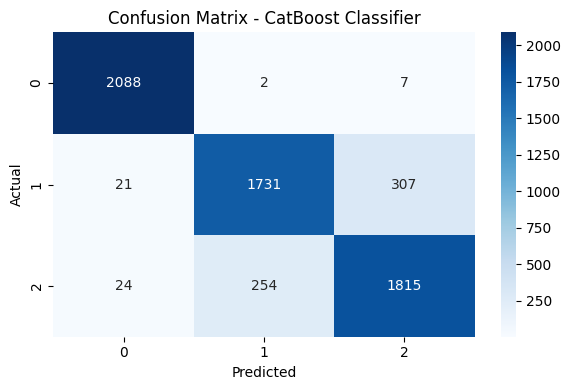

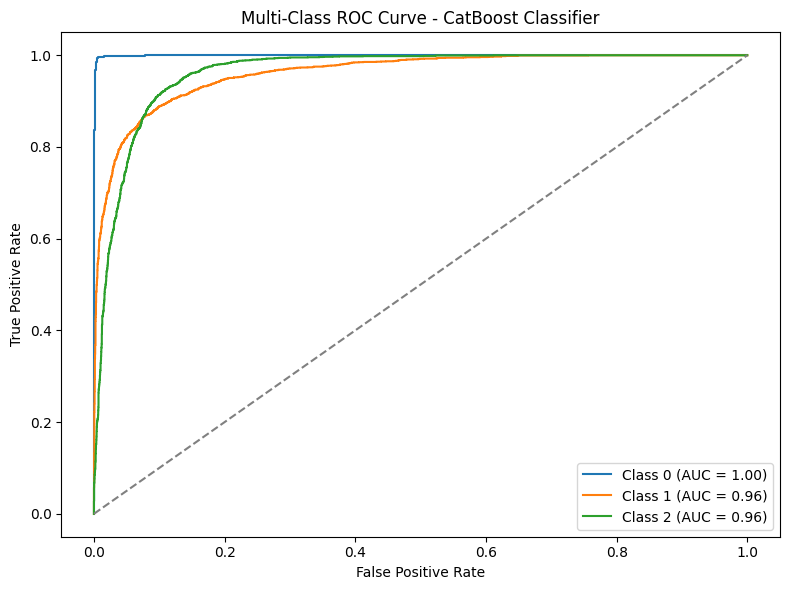

Training LightGBM Classifier...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 24996, number of used features: 16
[LightGBM] [Info] Start training from score -1.100294
[LightGBM] [Info] Start training from score -1.095736
[LightGBM] [Info] Start training from score -1.099813
Confusion Matrix for LightGBM Classifier:
 [[2075   13    9]
 [  37 1653  369]
 [  30  274 1789]]


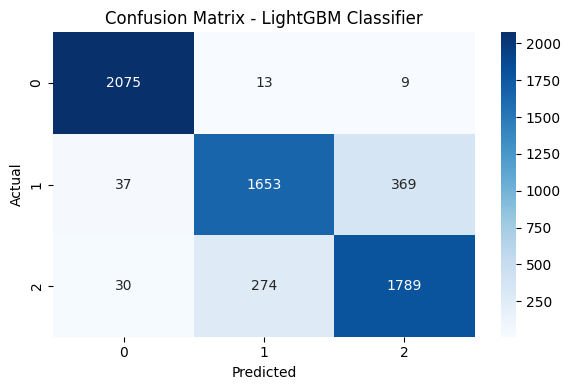

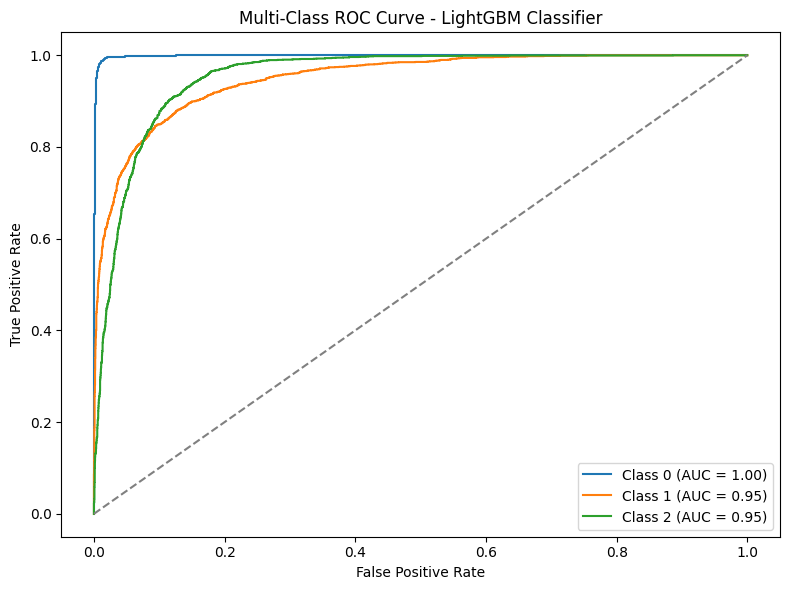


Comparison Table:
                 Model  Accuracy  F1 Score  Precision    Recall       MAE  \
0        Random Forest  0.912146  0.911988   0.911872  0.912146  0.090895   
1    Gradient Boosting  0.772444  0.770910   0.770204  0.772444  0.255241   
2  K-Nearest Neighbors  0.831813  0.819879   0.861260  0.831813  0.200672   
3              XGBoost  0.908945  0.908684   0.908848  0.908945  0.095375   
4  CatBoost Classifier  0.901584  0.901193   0.901071  0.901584  0.103377   
5  LightGBM Classifier  0.882861  0.882235   0.882335  0.882861  0.123380   

        MSE  
0  0.096976  
1  0.310610  
2  0.265643  
3  0.104017  
4  0.113298  
5  0.135862  


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = (
        model.predict_proba(X_test)
        if hasattr(model, "predict_proba")
        else None
    )
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store metrics in results
    results[name] = (y_pred, y_prob, accuracy, f1, precision, recall, mae, mse)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {name}:\n", cm)
    plot_confusion_matrix(cm, name)
    
    # Multi-Class ROC Curve
    if y_prob is not None and y_test_binarized.shape[1] == y_prob.shape[1]:
        plot_multi_class_roc(y_test_binarized, y_prob, name, classes)

# Create Comparison Table
comparison = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [result[2] for result in results.values()],
    "F1 Score": [result[3] for result in results.values()],
    "Precision": [result[4] for result in results.values()],
    "Recall": [result[5] for result in results.values()],
    "MAE": [result[6] for result in results.values()],
    "MSE": [result[7] for result in results.values()]
})

# Print and Save Comparison Table
print("\nComparison Table:")
print(comparison)
comparison.to_csv("model_comparison_metrics.csv", index=False)



Chi-Square Feature Scores:
        Feature  Chi-Square Score       p-Value
12  Feature_12       1507.635773  0.000000e+00
2    Feature_2        296.292668  4.579990e-65
11  Feature_11        271.453734  1.133889e-59
1    Feature_1        243.988621  1.043624e-53
29  Feature_29        131.500383  2.786472e-29
25  Feature_25        122.830085  2.127090e-27
7    Feature_7        103.012818  4.276128e-23
22  Feature_22         78.352114  9.683995e-18
24  Feature_24         72.327825  1.968849e-16
28  Feature_28         70.294845  5.440870e-16
30  Feature_30         42.796713  5.091102e-10
23  Feature_23         31.662700  1.332085e-07
8    Feature_8         31.384198  1.531116e-07
17  Feature_17         29.358950  4.214877e-07
14  Feature_14         28.897532  5.308607e-07
6    Feature_6         27.037757  1.345320e-06
20  Feature_20         27.030704  1.350073e-06
19  Feature_19          0.080261  9.606639e-01
16  Feature_16          0.071777  9.647480e-01
10  Feature_10          0.05701

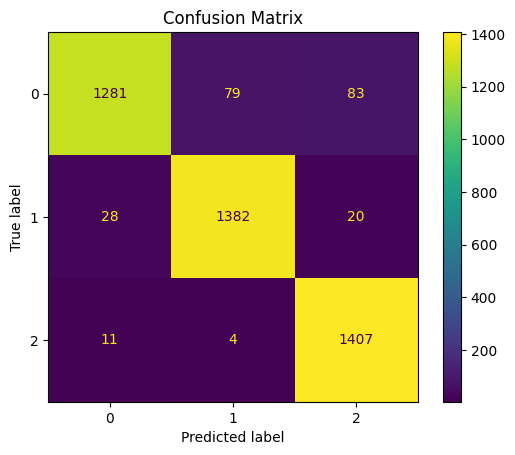

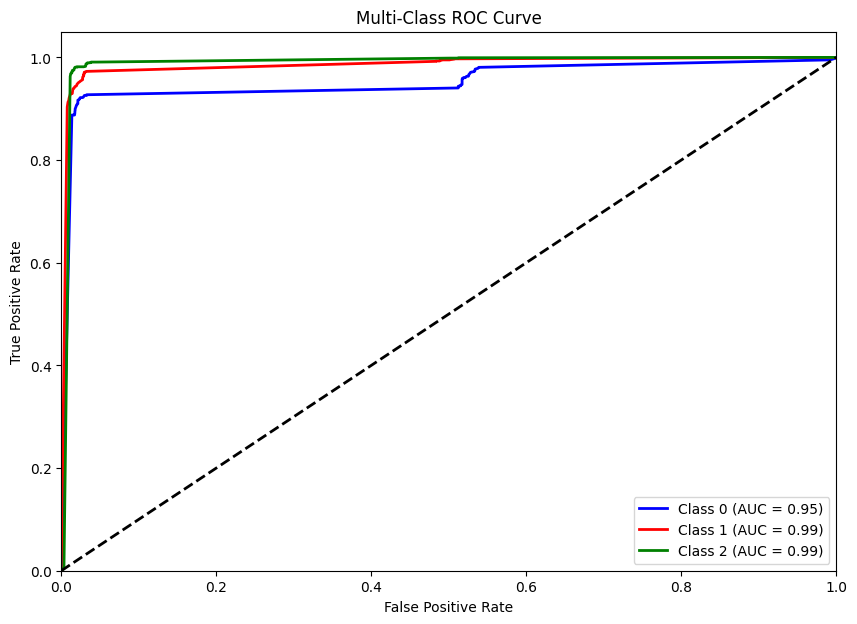

In [21]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from itertools import cycle

# Step 1: Generate a synthetic dataset
X, y = make_classification(
    n_samples=12000, n_features=32, n_informative=15, n_redundant=5, 
    n_clusters_per_class=2, weights=[0.6, 0.3, 0.1], n_classes=3, random_state=42
)

# Step 2: Perform Chi-Square feature selection
feature_names = [f"Feature_{i}" for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)
y_df = pd.Series(y, name="Target")

# Shift feature values to be non-negative for Chi-Square test
X_df += abs(X_df.min().min())

chi_scores, p_values = chi2(X_df, y_df)
chi2_df = pd.DataFrame({
    'Feature': feature_names,
    'Chi-Square Score': chi_scores,
    'p-Value': p_values
}).sort_values(by='Chi-Square Score', ascending=False)

print("\nChi-Square Feature Scores:\n", chi2_df)

# Select features with p-value < threshold
threshold = 0.05
selected_features = chi2_df[chi2_df['p-Value'] < threshold]['Feature'].tolist()
print("\nSelected Features:", selected_features)

# Filter dataset based on selected features
X_filtered = X_df[selected_features].values

# Step 3: Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_filtered, y)

# Step 4: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 5: Initialize parameters
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Step 6: Initialize base learners and meta-learner
base_learners = [XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=i) for i in range(k_folds)]
meta_learner = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Step 7: Generate predictions for training the meta-learner
meta_features = np.zeros((len(y_train), k_folds))  # Rows: samples, Columns: base learners
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Train the base learner on k-1 folds
    base_learners[fold_idx].fit(X_train_fold, y_train_fold)
    
    # Predict the validation fold and store the predictions
    val_predictions = base_learners[fold_idx].predict(X_val_fold)
    meta_features[val_idx, fold_idx] = val_predictions  # Fill meta-features for this fold

# Step 8: Train the XGBClassifier meta-learner on the aggregated predictions
meta_learner.fit(meta_features, y_train)

# Step 9: Generate predictions on the test set
# Create meta-features for the test set by aggregating predictions from base learners
test_meta_features = np.column_stack([
    base_learner.predict(X_test) for base_learner in base_learners
])
final_predictions = meta_learner.predict(test_meta_features)

# Step 10: Evaluate the stacked model
accuracy = accuracy_score(y_test, final_predictions)
print(f"Self-Stacking Ensemble using XGBClassifier Test Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, final_predictions))

# Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

# Step 11: Plot ROC curve
fpr, tpr, roc_auc = {}, {}, {}
n_classes = len(np.unique(y))
# Binarize the target variable for ROC curve computation
y_test_bin = np.eye(n_classes)[y_test]
final_proba = meta_learner.predict_proba(test_meta_features)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], final_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])  # Extend as needed for more classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()


 99%|===================| 12789/12885 [00:37<00:00]       

<Figure size 1000x700 with 0 Axes>

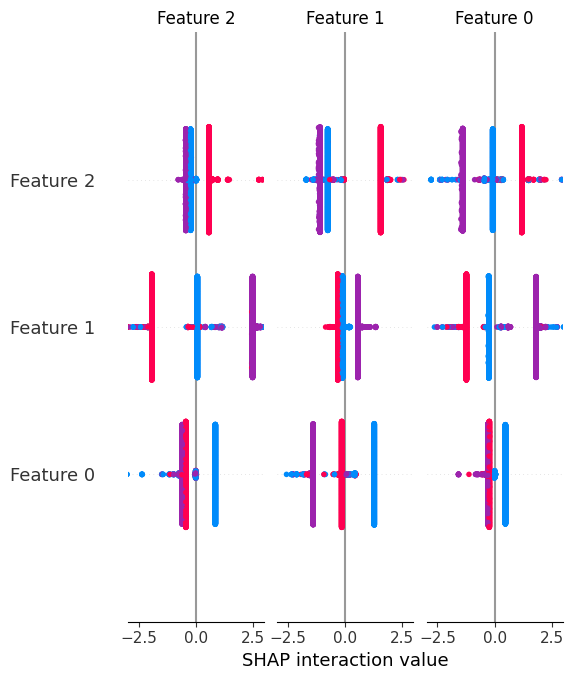

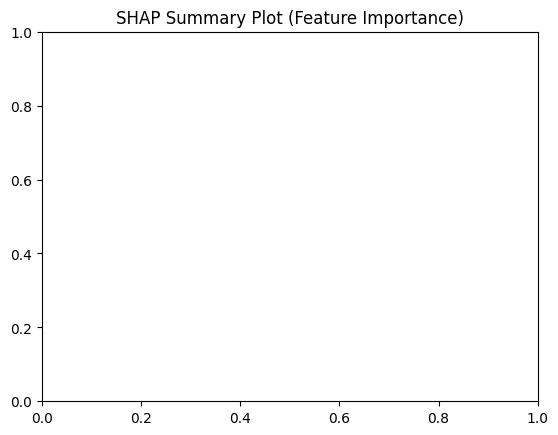

In [22]:
import shap
import matplotlib.pyplot as plt

# Step 1: Train the final model (already done in your code)
# The meta_learner (XGBClassifier) is the final model trained on stacked features.

# Step 2: Explain the model's predictions using SHAP
explainer = shap.Explainer(meta_learner, test_meta_features)  # Create SHAP explainer
shap_values = explainer(test_meta_features)  # Compute SHAP values for test set

# Step 3: Generate SHAP summary plot
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, test_meta_features)
plt.title("SHAP Summary Plot (Feature Importance)")
plt.show()
